# Arabic Sentiment Analysis using ML, DL (LSTM), and Transformers (Hugging Face)

This notebook demonstrates three different approaches to classify the sentiment of Arabic tweets:

1.  **Traditional Machine Learning:** Using TF-IDF vectorization with various classifiers.
2.  **Deep Learning (LSTM):** Using a Bidirectional LSTM model with word embeddings.
3.  **Transformers:** Fine-tuning a pre-trained Arabic Transformer model from the Hugging Face library.

The notebook includes data loading, core preprocessing, method-specific processing, model training, evaluation, and saving trained models and artifacts locally.

---
## 1. Setup, Data Loading, and Core Preprocessing

This section handles importing common libraries, configuring paths, loading the dataset, applying initial text cleaning and normalization, creating processed text columns, and preparing data splits.

In [1]:
!pip install -q -U pandas nltk scikit-learn xgboost emoji matplotlib seaborn datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

In [3]:
# --- Setup, Data Loading, and Core Preprocessing ---

# 1. Import Common Libraries
import pandas as pd
import numpy as np
import re
import nltk
import emoji
import os
import datasets
import sys
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --- ML Libraries (used in Method 1, imported here as part of core setup) ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

#Configure Matplotlib for inline display in notebooks
# This line is specific to Jupyter/Colab notebooks
%matplotlib inline


#Download required NLTK resources if not already present
print("Checking for NLTK stopwords...")
try:
    nltk.data.find('corpora/stopwords')
    print("NLTK stopwords found.")
except LookupError:
    print("NLTK stopwords not found. Downloading...")
    nltk.download('stopwords')
    print("NLTK stopwords downloaded.")


# --- Configuration ---
# Set to True to display confusion matrix plots
PLOT_CONFUSION_MATRIX = True
# Set to True to save the best *traditional ML* model and vectorizer
SAVE_ML_ARTIFACTS = True
# Set to True to save the Transformer model
SAVE_TRANSFORMER_ARTIFACTS = True


# Function to check if running in Google Colab
def is_running_in_colab():
    return 'google.colab' in sys.modules

# Define data path based on environment
if is_running_in_colab():
    print("Running in Google Colab environment.")
#Update this path to where YOUR dataset is located in Google Drive !!!
    BASE_PATH = "/content/drive/MyDrive/Sentiment Analysis"
    print(f"Set data BASE_PATH to Google Drive: {BASE_PATH}")
else:
    print("Running in a local environment.")
    # Adjust this path if your data files are located elsewhere locally
    BASE_PATH = "./data/"
    print(f"Set data BASE_PATH to local: {BASE_PATH}")


# Define fixed local directory for saving all models and artifacts
DESTINATION_DIR = "./saved_artifacts/"

# Ensure the local destination directory exists
if not os.path.exists(DESTINATION_DIR):
    os.makedirs(DESTINATION_DIR, exist_ok=True)
    print(f"Created local save directory: {DESTINATION_DIR}")


# Define full paths for data files using the determined BASE_PATH
TRAIN_POS_PATH = os.path.join(BASE_PATH, "train_Arabic_tweets_positive_20190413.tsv")
TRAIN_NEG_PATH = os.path.join(BASE_PATH, "train_Arabic_tweets_negative_20190413.tsv")
TEST_POS_PATH = os.path.join(BASE_PATH, "test_Arabic_tweets_positive_20190413.tsv")
TEST_NEG_PATH = os.path.join(BASE_PATH, "test_Arabic_tweets_negative_20190413.tsv")

# Define filenames/directory names for saved artifacts within DESTINATION_DIR
MODEL_FILENAME = "best_sentiment_model.pkl"
VECTORIZER_FILENAME = "tfidf_vectorizer.pkl"
TRANSFORMER_MODEL_DIR_NAME = "transformer_sentiment_model"
TRANSFORMER_MODEL_SAVE_PATH = os.path.join(DESTINATION_DIR, TRANSFORMER_MODEL_DIR_NAME)


# --- DL Configuration (kept here for easy access across methods) ---
VOCAB_SIZE = 10000  # Max number of words to keep in the vocabulary for Method 2 (LSTM)
MAX_SEQUENCE_LENGTH = 100  # Max length for input sequences (padding/truncating) for Method 2 (LSTM)
EMBEDDING_DIM = 128 # Dimension of the embedding vectors for Method 2 (LSTM)
LSTM_UNITS = 64 # Number of units in the LSTM layer for Method 2 (LSTM)
BATCH_SIZE_LSTM = 64 # Batch size for training LSTM model
EPOCHS_LSTM = 2 # Max number of epochs for training LSTM model
PATIENCE_LSTM = 3 # Patience for Early Stopping in LSTM training

# --- Transformer Configuration (kept here for easy access across methods) ---
TRANSFORMER_MODEL_NAME = "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment"   # A good Arabic BERT model
MAX_SEQUENCE_LENGTH_TRANSFORMER = 128 # Transformers typically use lengths like 128 or 512
BATCH_SIZE_TRANSFORMER = 32
EPOCHS_TRANSFORMER = 2 #transformer training epochs
PATIENCE_TRANSFORMER = 2 # Patience for Early Stopping in Transformer training
LEARNING_RATE_TRANSFORMER = 5e-5 # Common learning rate for Transformer fine-tuning




#Load Dataset
print("Loading data from files...")
# Initialize dataframes to None before loading
train_df = None
test_df = None
try:
    # Load data using pandas read_csv with utf-8 encoding for arabic
    train_pos = pd.read_csv(TRAIN_POS_PATH, sep='\t', header=None, names=['id', 'text'], on_bad_lines='skip', encoding='utf-8', low_memory=False)
    train_neg = pd.read_csv(TRAIN_NEG_PATH, sep='\t', header=None, names=['id', 'text'], on_bad_lines='skip', encoding='utf-8', low_memory=False)
    test_pos = pd.read_csv(TEST_POS_PATH, sep='\t', header=None, names=['id', 'text'], on_bad_lines='skip', encoding='utf-8', low_memory=False)
    test_neg = pd.read_csv(TEST_NEG_PATH, sep='\t', header=None, names=['id', 'text'], on_bad_lines='skip', encoding='utf-8', low_memory=False)

    train_pos['label'] = 1
    train_neg['label'] = 0
    test_pos['label'] = 1
    test_neg['label'] = 0

    train_df = pd.concat([train_pos, train_neg], ignore_index=True)
    test_df = pd.concat([test_pos, test_neg], ignore_index=True)

    # Drop rows with missing text data
    initial_train_rows = len(train_df)
    initial_test_rows = len(test_df)
    train_df.dropna(subset=['text'], inplace=True)
    test_df.dropna(subset=['text'], inplace=True)
    print(f"Dropped {initial_train_rows - len(train_df)} rows with missing text from training data.")
    print(f"Dropped {initial_test_rows - len(test_df)} rows with missing text from testing data.")

    # Check if dataframes are empty after dropping NaNs
    if train_df.empty or test_df.empty:
        print("Critical Error: Dataframes are empty after loading and dropping missing text.")
        sys.exit(1)

    # Shuffle the dataframes for good training
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    test_df = test_df.sample(frac=1).reset_index(drop=True)

    print(f"Training data shape after loading and cleaning: {train_df.shape}")
    print(f"Testing data shape after loading and cleaning: {test_df.shape}")
    print("Data loaded successfully.")

except FileNotFoundError:
    print(f"Critical Error: One or more data files not found.")
    print(f"Please ensure your data files are in the correct location: {BASE_PATH}")
    sys.exit(1) # Exit the script if essential files are not found
except Exception as e:
    # Catch any other exceptions during loading
    print(f"Critical Error occurred during data loading: {e}")
    sys.exit(1) # Exit on other critical loading errors


# Display some info about the loaded data
print("\nTrain Data Info:")
train_df.info()
print("\nTest Data Info:")
test_df.info()


#Enhanced Text Cleaning and Preprocessing Functions
#(Common preprocessing for both ML, DL, and Transformer methods)
def normalize_arabic(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'ى', 'ي', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'[ؤئ]', 'ء', text)
    return text

def clean_text_enhanced(text):
    if not isinstance(text, str): return ""
    # Replace emojis with their text description (e.g., ":smiling_face_with_smiling_eyes:")
    text = emoji.demojize(text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Remove mentions (@users)
    text = re.sub(r"@[\w_]+", "", text)
    # Remove hashtags symbol, keep the text
    text = re.sub(r"#", "", text)
    # Remove characters that are not Arabic letters, English letters, numbers, spaces, underscore, or colon (for demojized text)
    # Added handling for apostrophes which might appear in English text or demojized emojis
    text = re.sub(r"[^\u0600-\u06FF\sA-Za-z0-9_:'-]+", "", text)
    # Normalize Arabic characters
    text = normalize_arabic(text)
    # Replace multiple spaces with a single space and strip leading/trailing spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Get Arabic stopwords - ensure they are loaded
try:
    arabic_stopwords = set(stopwords.words('arabic'))
except LookupError:
     print("Arabic stopwords not found even after initial download attempt. Please check your NLTK installation and download.")
     sys.exit(1)


# Added more common arabic words that might not carry sentiment
custom_stopwords = {
    'في', 'و', 'علي', 'من', 'الي', 'انا', 'انت', 'هو', 'هي', 'كل', 'ده', 'دا',
    'دي', 'يا', 'أو', 'ما', 'أن', 'إذا', 'إن', 'لا', 'على', 'بالله', 'الله', 'كان',
    'يكون', 'كانت', 'هم', 'هن', 'انتم', 'انتن', 'كنا', 'لكن', 'ولكن', 'حتى', 'بين',
    'عند', 'بعد', 'قبل', 'فوق', 'تحت', 'الى', 'عن', 'مع', 'هذا', 'هذه', 'ذلك', 'تلك'
}
arabic_stopwords.update(custom_stopwords)

def preprocess_text_final(text, remove_stopwords=True):
    if not isinstance(text, str): return ""
    cleaned_text = clean_text_enhanced(text)
    tokens = cleaned_text.split()
    if remove_stopwords:
      # Remove stopwords and single characters
      tokens = [word for word in tokens if word.lower() not in arabic_stopwords and len(word) > 1]
    else:
      # Keep all tokens but remove empty strings and single characters (optional, but good practice)
      tokens = [word for word in tokens if len(word) > 1] # Keep words with length > 1

    return " ".join(tokens)

print("\nApplying preprocessing...")
# Ensure 'text' column is string type before applying apply
train_df['text'] = train_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

# Apply preprocessing for ML (with stopword removal) and handle potential NaNs
train_df['processed_text_ml'] = train_df['text'].apply(lambda x: preprocess_text_final(x, remove_stopwords=True)).fillna('')
test_df['processed_text_ml'] = test_df['text'].apply(lambda x: preprocess_text_final(x, remove_stopwords=True)).fillna('')

# Apply preprocessing for DL/Transformer (keeping more context) and handle potential NaNs
# Transformers handle stopwords internally through their training data, so removing is often not necessary.
# Keeping words > 1 character still helps with noise.
train_df['processed_text_dl_transformer'] = train_df['text'].apply(lambda x: preprocess_text_final(x, remove_stopwords=False)).fillna('')
test_df['processed_text_dl_transformer'] = test_df['text'].apply(lambda x: preprocess_text_final(x, remove_stopwords=False)).fillna('')


print("Preprocessing complete.")




# --- Prepare data splits ---
# Use the appropriate processed text columns for each method
X_train_text_ml = train_df['processed_text_ml']
X_test_text_ml = test_df['processed_text_ml']

X_train_text_dl_transformer = train_df['processed_text_dl_transformer']
X_test_text_dl_transformer = test_df['processed_text_dl_transformer']

y_train = train_df['label'].values # Use .values for numpy array (better for TF)
y_test = test_df['label'].values # Use .values for numpy array

Checking for NLTK stopwords...
NLTK stopwords found.
Running in Google Colab environment.
Set data BASE_PATH to Google Drive: /content/drive/MyDrive/Sentiment Analysis
Loading data from files...
Dropped 0 rows with missing text from training data.
Dropped 0 rows with missing text from testing data.
Training data shape after loading and cleaning: (45275, 3)
Testing data shape after loading and cleaning: (11520, 3)
Data loaded successfully.

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45275 entries, 0 to 45274
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45275 non-null  object
 1   text    45275 non-null  object
 2   label   45275 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11520 entries, 0 to 11519
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0  

In [4]:
# Display Data Head (default pandas format)
print("\nTrain Data Head:")
train_df.head()


Train Data Head:


,id,text,label,processed_text_ml,processed_text_dl_transformer
0,neg,اللي بيحب لو كان حب من البدايه مكنش سابك وقت و...,0,اللي بيحب حب البدايه مكنش سابك وقت وجعك وقت مح...,اللي بيحب لو كان حب من البدايه مكنش سابك وقت و...
1,neg,الاستديو حقي كله صور عجاج 😬,0,الاستديو حقي كله صور عجاج :grimacing_face:,الاستديو حقي كله صور عجاج :grimacing_face:
2,pos,كل الحب والاحترام لأشقائنا في سوريا الحبيبة جي...,1,الحب والاحترام لاشقاءنا سوريا الحبيبه جيشا وشع...,كل الحب والاحترام لاشقاءنا في سوريا الحبيبه جي...
3,pos,-لعلها تشفع لي ولكم ♥ _﴿ واذكر ربك إذا نسيت ﴾ ...,1,-لعلها تشفع ولكم :heart_suit: واذكر ربك اذا نس...,-لعلها تشفع لي ولكم :heart_suit: واذكر ربك اذا...
4,neg,ريوق تايم ✋,0,ريوق تايم :raised_hand:,ريوق تايم :raised_hand:


In [5]:
print("\nTest Data Head:")
test_df.head()


Test Data Head:


,id,text,label,processed_text_ml,processed_text_dl_transformer
0,pos,#يوم_الجمعه #كم_مغرد_بالصلاه_على_النبي #اللهم_...,1,يوم_الجمعه كم_مغرد_بالصلاه_علي_النبي اللهم_صل_...,يوم_الجمعه كم_مغرد_بالصلاه_علي_النبي اللهم_صل_...
1,pos,"ألطف ما قيل في الإشتياق ""مو ضروري إني أقولك.. ...",1,الطف قيل الاشتياق مو ضروري اني اقولك ايه واحشن...,الطف ما قيل في الاشتياق مو ضروري اني اقولك قد ...
2,neg,في الجانب المظلم من هذا اليوم هناك ميلن . 😔,0,الجانب المظلم اليوم ميلن :pensive_face:,في الجانب المظلم من هذا اليوم هناك ميلن :pensi...
3,neg,#بيت_شعري_تحسه_يمثلك احمد الله ما بقى لي على ا...,0,بيت_شعري_تحسه_يمثلك احمد بقي الدنيا حسوف الفرح...,بيت_شعري_تحسه_يمثلك احمد الله ما بقي لي علي ال...
4,pos,انتي من اكونتك الجديد يا 🐔 اكيد راضي بيهو ما ت...,1,انتي اكونتك الجديد :chicken: اكيد راضي بيهو تر...,انتي من اكونتك الجديد يا :chicken: اكيد راضي ب...


In [6]:
# Display some info about processed data
print("\nTrain Processed Text Head (ML):")
train_df['processed_text_ml'].head()


Train Processed Text Head (ML):


,processed_text_ml
0,اللي بيحب حب البدايه مكنش سابك وقت وجعك وقت مح...
1,الاستديو حقي كله صور عجاج :grimacing_face:
2,الحب والاحترام لاشقاءنا سوريا الحبيبه جيشا وشع...
3,-لعلها تشفع ولكم :heart_suit: واذكر ربك اذا نس...
4,ريوق تايم :raised_hand:


In [7]:
print("\nTrain Processed Text Head (DL/Transformer):")
train_df['processed_text_dl_transformer'].head()


Train Processed Text Head (DL/Transformer):


,processed_text_dl_transformer
0,اللي بيحب لو كان حب من البدايه مكنش سابك وقت و...
1,الاستديو حقي كله صور عجاج :grimacing_face:
2,كل الحب والاحترام لاشقاءنا في سوريا الحبيبه جي...
3,-لعلها تشفع لي ولكم :heart_suit: واذكر ربك اذا...
4,ريوق تايم :raised_hand:


## 2. Method 1: Traditional Machine Learning

This section implements sentiment analysis using TF-IDF vectorization and several classic machine learning classifiers. It includes training, evaluation, and saving the best performing model and the vectorizer.


========== Method 1: Traditional Machine Learning ==========

Vectorizing text data using TF-IDF (for ML models)...
TF-IDF Vectorization complete.
Shape of TF-IDF matrix (Train): (45275, 26029)
Shape of TF-IDF matrix (Test): (11520, 26029)

Training and evaluating ML models...

--- Training Logistic Regression ---
 ML Results for Logistic Regression:
  Accuracy:  0.9303
  Precision: 0.9185
  Recall:    0.9442
  F1 Score:  0.9312
  Confusion Matrix:
[[5286  482]
 [ 321 5431]]


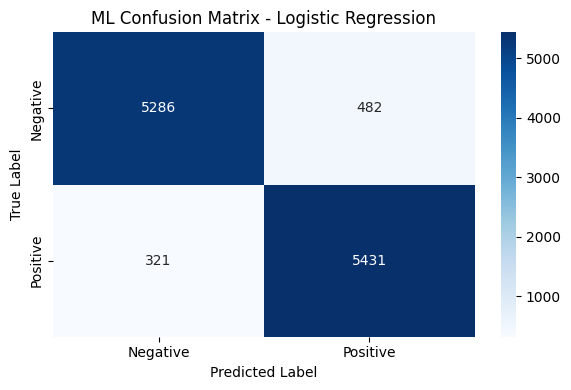


--- Training Multinomial Naive Bayes ---
 ML Results for Multinomial Naive Bayes:
  Accuracy:  0.8813
  Precision: 0.9070
  Recall:    0.8494
  F1 Score:  0.8773
  Confusion Matrix:
[[5267  501]
 [ 866 4886]]


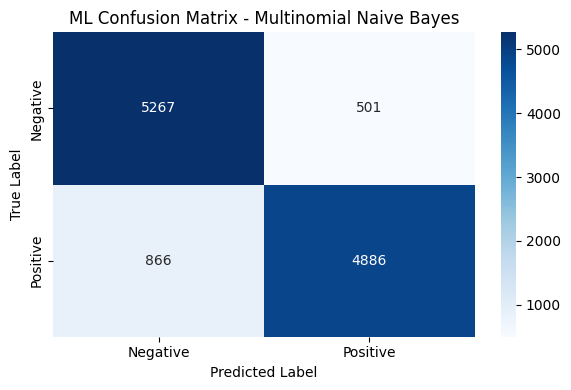


--- Training Linear SVC ---
 ML Results for Linear SVC:
  Accuracy:  0.9328
  Precision: 0.9306
  Recall:    0.9352
  F1 Score:  0.9329
  Confusion Matrix:
[[5367  401]
 [ 373 5379]]


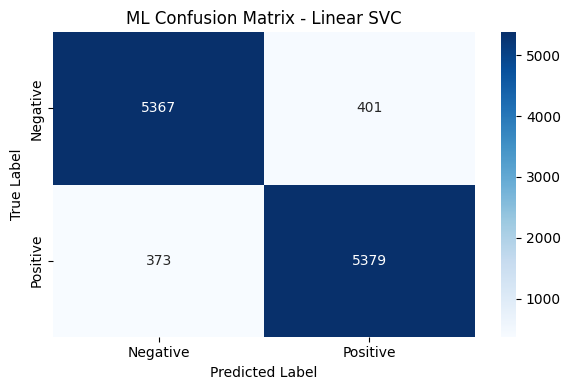


--- Training Random Forest (Bagging) ---
 ML Results for Random Forest (Bagging):
  Accuracy:  0.9416
  Precision: 0.9473
  Recall:    0.9350
  F1 Score:  0.9411
  Confusion Matrix:
[[5469  299]
 [ 374 5378]]


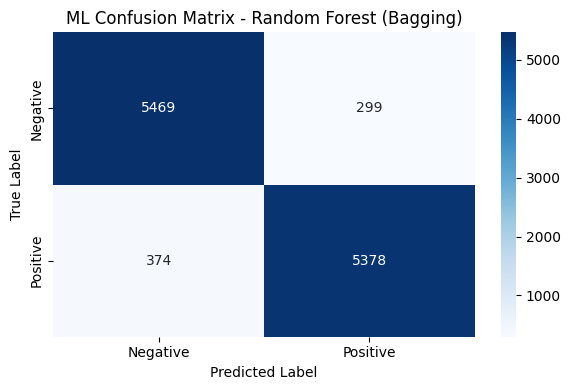


--- Training XGBoost (Boosting) ---
 ML Results for XGBoost (Boosting):
  Accuracy:  0.9107
  Precision: 0.8688
  Recall:    0.9671
  F1 Score:  0.9153
  Confusion Matrix:
[[4928  840]
 [ 189 5563]]


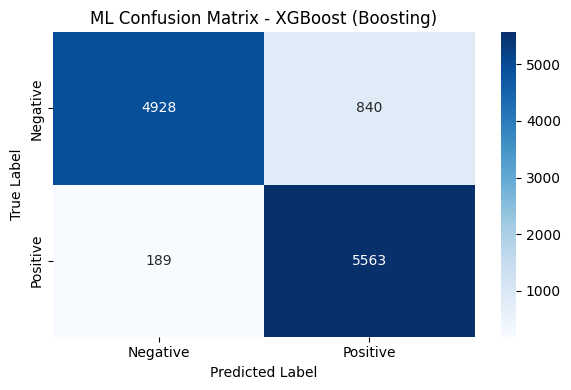


--- Overall ML Model Comparison ---
                         Accuracy Precision    Recall  F1 Score
Random Forest (Bagging)   0.94158  0.947331  0.934979  0.941115
Linear SVC               0.932813  0.930623  0.935153  0.932882
Logistic Regression      0.930295  0.918485  0.944193  0.931162
XGBoost (Boosting)       0.910677  0.868811  0.967142  0.915343
Multinomial Naive Bayes  0.881337  0.906998  0.849444  0.877278

--- Saving ML Artifacts (Joblib) ---
Selected 'Random Forest (Bagging)' as the best ML model for saving.
Successfully saved ML model 'Random Forest (Bagging)' to ./saved_artifacts/best_sentiment_model.pkl
Successfully saved TF-IDF vectorizer to ./saved_artifacts/tfidf_vectorizer.pkl


In [8]:
# --- Method 1: Traditional Machine Learning ---
print("\n" + "="*60)
print(" Method 1: Traditional Machine Learning ".center(60, "="))
print("="*60)

#Vectorization (TF-IDF) for Method 1
print("\nVectorizing text data using TF-IDF (for ML models)...")
# Use data processed with stopword removal for TF-IDF
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, ngram_range=(1, 2))

# Check if training text data is empty before vectorizing
if not X_train_text_ml.empty:
    X_train_tfidf = vectorizer.fit_transform(X_train_text_ml)
    X_test_tfidf = vectorizer.transform(X_test_text_ml)
    print("TF-IDF Vectorization complete.")
    print(f"Shape of TF-IDF matrix (Train): {X_train_tfidf.shape}")
    print(f"Shape of TF-IDF matrix (Test): {X_test_tfidf.shape}")
else:
    print("Training text data is empty. Skipping TF-IDF vectorization.")
    X_train_tfidf = None # Assign None if vectorization is skipped
    X_test_tfidf = None
    vectorizer = None


#Define, Train, and Evaluate ML Classifiers
print("\nTraining and evaluating ML models...")
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42, solver='liblinear'),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Linear SVC": LinearSVC(max_iter=2000, random_state=42, dual=True),
    "Random Forest (Bagging)": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost (Boosting)": XGBClassifier(random_state=42,eval_metric='logloss', n_estimators=100)
}
ml_results = {}
trained_ml_models = {}

# Only proceed if TF-IDF vectorization was successful
if X_train_tfidf is not None and X_test_tfidf is not None:
    for name, clf in classifiers.items():
        print(f"\n--- Training {name} ---")
        # Check if training data is empty before training
        if X_train_tfidf.shape[0] == 0 or y_train.size == 0:
            print(f"Skipping training for {name}: Training data is empty.")
            continue # Skip to the next classifier

        clf.fit(X_train_tfidf, y_train)
        trained_ml_models[name] = clf

        # Check if test data is empty before predicting and evaluating
        if X_test_tfidf.shape[0] == 0 or y_test.size == 0:
             print(f"Skipping evaluation for {name}: Test data is empty.")
             ml_results[name] = {'Accuracy': 0, 'Precision': 0, 'Recall': 0, 'F1 Score': 0, 'Confusion Matrix': np.array([[0,0],[0,0]])} # Record zero metrics
             continue # Skip to the next classifier

        y_pred_ml = clf.predict(X_test_tfidf)
        # Evaluate
        accuracy = accuracy_score(y_test, y_pred_ml)
        precision = precision_score(y_test, y_pred_ml, zero_division=0)
        recall = recall_score(y_test, y_pred_ml, zero_division=0)
        f1 = f1_score(y_test, y_pred_ml, zero_division=0)
        cm = confusion_matrix(y_test, y_pred_ml)
        ml_results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Confusion Matrix': cm}
        # Print metrics
        print(f" ML Results for {name}:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1 Score:  {f1:.4f}")
        print(f"  Confusion Matrix:\n{cm}")
        # Plot Confusion Matrix
        if PLOT_CONFUSION_MATRIX:
            try:
                plt.figure(figsize=(6, 4))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
                plt.title(f'ML Confusion Matrix - {name}')
                plt.xlabel('Predicted Label')
                plt.ylabel('True Label')
                plt.tight_layout()
                plt.show()
            except Exception as plot_err:
                print(f"Could not plot ML confusion matrix for {name}: {plot_err}")
else:
    print("\nSkipping ML model training and evaluation due to unsuccessful TF-IDF vectorization.")


#Summary of ML Results
print("\n--- Overall ML Model Comparison ---")
if ml_results:
    ml_results_df = pd.DataFrame(ml_results).T.drop(columns=['Confusion Matrix'])
    print(ml_results_df.sort_values(by='F1 Score', ascending=False))
else:
    print("No ML results available to display.")


#Save ML Artifacts (Best ML Model and Vectorizer)
# Only attempt to save if saving is enabled and a best model/vectorizer exist from successful runs
if SAVE_ML_ARTIFACTS and trained_ml_models and vectorizer is not None and ml_results:
    print("\n--- Saving ML Artifacts (Joblib) ---")

    # Determine the best ML model based on F1 Score from evaluated models
    best_ml_model_for_saving = None
    best_ml_model_name_for_saving = "N/A"
    ml_results_df_for_saving = pd.DataFrame(ml_results).T # Use the results dataframe
    if not ml_results_df_for_saving.empty:
         best_ml_model_name_for_saving = ml_results_df_for_saving['F1 Score'].idxmax()
         best_ml_model_for_saving = trained_ml_models.get(best_ml_model_name_for_saving)
         print(f"Selected '{best_ml_model_name_for_saving}' as the best ML model for saving.")
    else:
         print("No ML results available to select the best model for saving.")


    if best_ml_model_for_saving:
        # Define full save paths within the DESTINATION_DIR
        model_save_path = os.path.join(DESTINATION_DIR, MODEL_FILENAME)
        vectorizer_save_path = os.path.join(DESTINATION_DIR, VECTORIZER_FILENAME)

        # --- Save the best ML model and the vectorizer locally ---
        joblib.dump(best_ml_model_for_saving, model_save_path)
        print(f"Successfully saved ML model '{best_ml_model_name_for_saving}' to {model_save_path}")

        joblib.dump(vectorizer, vectorizer_save_path)
        print(f"Successfully saved TF-IDF vectorizer to {vectorizer_save_path}")
    else:
        print("No best ML model found or selected for saving.")


else:
    print("\nSkipping saving ML artifacts based on configuration or unsuccessful training/artifact creation/evaluation.")

## 3. Method 2: Deep Learning (LSTM)

This section implements a sentiment analysis model using a Bidirectional LSTM layer with an Embedding layer. It includes tokenization, padding, model building, training, and evaluation.


============== Method 2: Deep Learning (LSTM) ==============

Tokenizing and padding sequences for LSTM...
Found 65766 unique tokens for LSTM.
Vocabulary size for LSTM Embedding layer: 10001
Tokenization and padding complete for LSTM.
Shape of padded training sequences (LSTM): (45275, 100)
Shape of padded testing sequences (LSTM): (11520, 100)

Building the LSTM model...
Using TensorFlow distribution strategy: _DefaultDistributionStrategy

Training the LSTM model...
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


708/708 ━━━━━━━━━━━━━━━━━━━━ 452s 621ms/step - accuracy: 0.8214 - loss: 0.3704 - val_accuracy: 0.9293 - val_loss: 0.1818
Epoch 2/2
708/708 ━━━━━━━━━━━━━━━━━━━━ 533s 671ms/step - accuracy: 0.9400 - loss: 0.1583 - val_accuracy: 0.9372 - val_loss: 0.1800
LSTM Model training complete.

Evaluating the LSTM model...
Evaluating on test set...

LSTM Model Performance on Test Set:
  Loss:      0.1800
  Accuracy:  0.9372
Getting LSTM predictions...
360/360 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step
  Precision: 0.9366
  Recall:    0.9376
  F1 Score:  0.9371
  Confusion Matrix:
[[5403  365]
 [ 359 5393]]


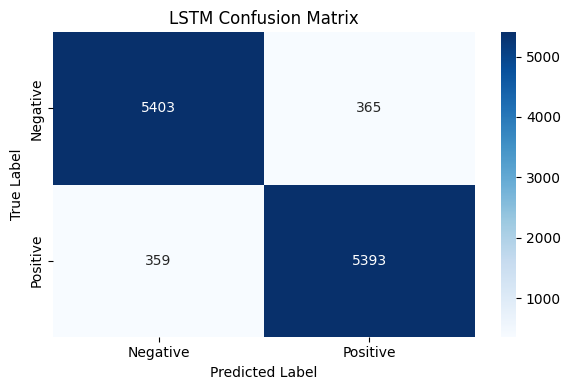

In [9]:
# --- Method 2: Deep Learning (LSTM) ---
print("\n" + "="*60)
print(" Method 2: Deep Learning (LSTM) ".center(60, "="))
print("="*60)

# Import DL Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, BatchNormalization, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#Tokenization and Padding for LSTM
print("\nTokenizing and padding sequences for LSTM...")
# Initialize tokenizer
# Use data processed WITHOUT stopword removal for DL/Transformer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>') # <OOV> for out-of-vocabulary words
vocab_size_dl = 0 # Initialize vocab size
X_train_pad_dl = np.array([]) # Initialize padded data as empty numpy arrays
X_test_pad_dl = np.array([])

# Fit tokenizer on training data (using text processed for DL/Transformer)
# Check if training text data is empty before fitting tokenizer
if not X_train_text_dl_transformer.empty:
    tokenizer.fit_on_texts(X_train_text_dl_transformer)
    word_index = tokenizer.word_index
    # Add 1 to vocab size for the OOV token and padding (if using 0 for padding)
    # Check if VOCAB_SIZE is smaller than actual unique words + 1
    actual_vocab_size = len(word_index) + 1
    if VOCAB_SIZE < actual_vocab_size:
        print(f"Warning: VOCAB_SIZE ({VOCAB_SIZE}) is smaller than the actual unique tokens ({actual_vocab_size - 1}). Some words will be treated as OOV.")
        vocab_size_dl = VOCAB_SIZE + 1 # Use the specified VOCAB_SIZE + 1 for embedding dimension
    else:
         vocab_size_dl = actual_vocab_size # Use the actual size if smaller


    print(f"Found {len(word_index)} unique tokens for LSTM.")
    print(f"Vocabulary size for LSTM Embedding layer: {vocab_size_dl}")


    # Convert texts to sequences of integers (using text processed for DL/Transformer)
    X_train_seq_dl = tokenizer.texts_to_sequences(X_train_text_dl_transformer)
    X_test_seq_dl = tokenizer.texts_to_sequences(X_test_text_dl_transformer)


    # Check if sequences are empty before padding
    if len(X_train_seq_dl) > 0 and len(X_test_seq_dl) > 0:
        # Pad sequences to ensure uniform length
        X_train_pad_dl = pad_sequences(X_train_seq_dl, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
        X_test_pad_dl = pad_sequences(X_test_seq_dl, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

        print("Tokenization and padding complete for LSTM.")
        print(f"Shape of padded training sequences (LSTM): {X_train_pad_dl.shape}")
        print(f"Shape of padded testing sequences (LSTM): {X_test_pad_dl.shape}")

    else:
         print("Tokenization resulted in empty sequences. Skipping padding for LSTM.")


else:
    print("Training text data is empty. Skipping tokenization and padding for LSTM.")
    tokenizer = None # Ensure tokenizer is None if not fitted


#Build the LSTM Model
print("\nBuilding the LSTM model...")
lstm_model = None # Initialize model to None
# Only build the model if vocabulary size is > 0 and padded data is not empty
if vocab_size_dl > 0 and X_train_pad_dl.size > 0:
    # Check if a GPU is available and use it
    strategy = tf.distribute.get_strategy()
    print(f"Using TensorFlow distribution strategy: {strategy.__class__.__name__}")

    with strategy.scope():
        lstm_model = Sequential([
            # Embedding layer: Maps integer sequences to dense vectors
            # input_dim is vocab size + 1 for the potential 0 padding
            Embedding(input_dim=vocab_size_dl, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),

            # Spatial Dropout: Drops entire 1D feature maps to prevent overfitting, often used after Embedding
            SpatialDropout1D(0.2),

            # LSTM Layer: Processes the sequence data
            # Using Bidirectional LSTM to capture context from both directions
            Bidirectional(LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2)), # Add dropout within LSTM

            # Batch Normalization: Normalize activations from LSTM layer
            BatchNormalization(),

            # Dense Layer: Further processing
            Dense(64, activation='relu'),
            # Output Layer: Sigmoid activation for binary classification
            Dense(1, activation='sigmoid')
        ])

        # Compile the model
        lstm_model.compile(loss='binary_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])
else:
    print("\nSkipping LSTM model building because vocabulary size is 0 or training data is empty.")


#Train the LSTM Model
print("\nTraining the LSTM model...")
# Define early stopping callback
early_stopping_lstm = EarlyStopping(monitor='val_loss', patience=PATIENCE_LSTM, restore_best_weights=True)

history_lstm = None # Initialize history to None
# Check if model exists and training data is not empty before training
if lstm_model and X_train_pad_dl.size > 0 and y_train.size > 0:
    history_lstm = lstm_model.fit(X_train_pad_dl, y_train,
                             epochs=EPOCHS_LSTM,
                             batch_size=BATCH_SIZE_LSTM,
                             validation_data=(X_test_pad_dl, y_test),
                             callbacks=[early_stopping_lstm],
                             verbose=1)
    print("LSTM Model training complete.")
else:
     print("\nSkipping LSTM model training because the model was not built or training data is empty.")


#Evaluate the LSTM Model
print("\nEvaluating the LSTM model...")
# Only evaluate if model was successfully built and training was attempted and history exists,
# and test data is available.
if lstm_model and history_lstm is not None and history_lstm.history and X_test_pad_dl.size > 0 and y_test.size > 0:
    print("Evaluating on test set...")
    # Use model.evaluate
    eval_results = lstm_model.evaluate(X_test_pad_dl, y_test, verbose=0)
    loss_lstm = eval_results[0]
    accuracy_lstm = eval_results[1]

    print(f"\nLSTM Model Performance on Test Set:")
    print(f"  Loss:      {loss_lstm:.4f}")
    print(f"  Accuracy:  {accuracy_lstm:.4f}")

    # Get predictions (probabilities)
    print("Getting LSTM predictions...")
    y_pred_prob_lstm = lstm_model.predict(X_test_pad_dl)
    # Convert probabilities to binary predictions (0 or 1)
    y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int).flatten() # Flatten to make it 1D array

    # Calculate other metrics
    precision_lstm = precision_score(y_test, y_pred_lstm, zero_division=0)
    recall_lstm = recall_score(y_test, y_pred_lstm, zero_division=0)
    f1_lstm = f1_score(y_test, y_pred_lstm, zero_division=0)
    cm_lstm = confusion_matrix(y_test, y_pred_lstm)

    print(f"  Precision: {precision_lstm:.4f}")
    print(f"  Recall:    {recall_lstm:.4f}")
    print(f"  F1 Score:  {f1_lstm:.4f}")
    print(f"  Confusion Matrix:\n{cm_lstm}")

    # Plot Confusion Matrix for LSTM
    if PLOT_CONFUSION_MATRIX:
        try:
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
            plt.title('LSTM Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.tight_layout()
            plt.show()
        except Exception as plot_err:
            print(f"Could not plot LSTM confusion matrix: {plot_err}")

else:
    print("\nLSTM model evaluation skipped due to unsuccessful model building, training, or empty test data.")

## 4. Method 3: Transformers using Hugging Face

This section demonstrates using a pre-trained Transformer model from Hugging Face `CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment`, fine-tuning it on the Arabic sentiment data, and evaluating its performance.


========== Method 3: Hugging Face Transformers ==========
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/45275 [00:00<?, ? examples/s]

Map:   0%|          | 0/11520 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/45275 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/11520 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.165000,0.187914,0.936719,0.936889,0.933092,0.940716
2,0.113300,0.160944,0.947569,0.947055,0.955092,0.939152



Test Results: {'eval_loss': 0.16094432771205902, 'eval_accuracy': 0.9475694444444445, 'eval_f1': 0.947054698457223, 'eval_precision': 0.9550919377652051, 'eval_recall': 0.9391515994436718, 'eval_runtime': 19.757, 'eval_samples_per_second': 583.084, 'eval_steps_per_second': 18.221, 'epoch': 2.0}

Confusion Matrix:
 [[5514  254]
 [ 350 5402]]


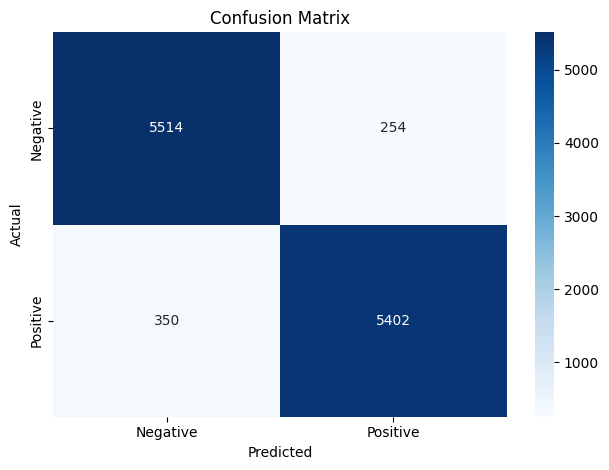


Model saved to ./saved_artifacts/transformer_sentiment_model


In [10]:
import torch
import datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)

print("\n" + "="*10 + " Method 3: Hugging Face Transformers " + "="*10)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare Hugging Face Datasets
train_dict = {'text': X_train_text_dl_transformer.tolist(), 'label': y_train.tolist()}
test_dict = {'text': X_test_text_dl_transformer.tolist(), 'label': y_test.tolist()}

train_dataset = datasets.Dataset.from_dict(train_dict)
test_dataset = datasets.Dataset.from_dict(test_dict)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    TRANSFORMER_MODEL_NAME,
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

# Tokenize data
def tokenize_function(examples):
    texts = [str(t) if t is not None else "" for t in examples["text"]]
    return tokenizer(texts, padding="max_length", truncation=True, max_length=MAX_SEQUENCE_LENGTH_TRANSFORMER)

tokenized_train = train_dataset.map(tokenize_function, batched=True).remove_columns(["text"])
tokenized_test = test_dataset.map(tokenize_function, batched=True).remove_columns(["text"])
# Set label type and format
tokenized_train = tokenized_train.cast_column("label", datasets.features.ClassLabel(names=[0, 1]))
tokenized_test = tokenized_test.cast_column("label", datasets.features.ClassLabel(names=[0, 1]))

tokenized_train.set_format("torch")
tokenized_test.set_format("torch")

# Metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary', zero_division=0)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Set training configuration
training_args = TrainingArguments(
    output_dir=TRANSFORMER_MODEL_SAVE_PATH,
    num_train_epochs=EPOCHS_TRANSFORMER,
    per_device_train_batch_size=BATCH_SIZE_TRANSFORMER,
    per_device_eval_batch_size=BATCH_SIZE_TRANSFORMER,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=os.path.join(TRANSFORMER_MODEL_SAVE_PATH, 'logs'),
    logging_steps=50,
    eval_strategy="epoch", # Automatically evaluates each epoch
    save_strategy="epoch",# Saves model each epoch
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    report_to="none",
    learning_rate=LEARNING_RATE_TRANSFORMER,
    gradient_accumulation_steps=1,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2 if torch.cuda.is_available() else 0
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE_TRANSFORMER)]
)

# Train model
trainer.train()

# Evaluate
results = trainer.evaluate()
print("\nTest Results:", results)

# Predict
predictions_output = trainer.predict(test_dataset=tokenized_test)
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

if PLOT_CONFUSION_MATRIX:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Save model
if SAVE_TRANSFORMER_ARTIFACTS:
    trainer.save_model(TRANSFORMER_MODEL_SAVE_PATH)
    print(f"\nModel saved to {TRANSFORMER_MODEL_SAVE_PATH}")
